# **Novel Grading Architecture**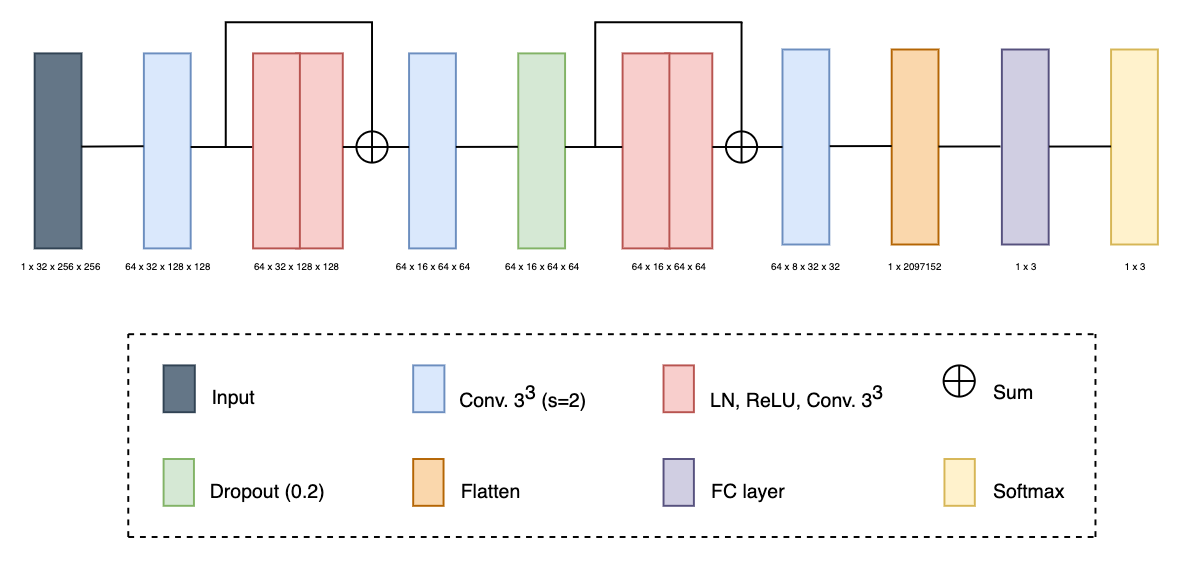

In [ ]:
import torch
import torch.nn as nn

# torch.Size([1, 1, 32, 256, 256])

class NovelGradingModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3))
    
    self.conv_res1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.norm = nn.LocalResponseNorm(size=5)
    self.relu = nn.ReLU()
    # self.maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2) no need
    self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    # hmmm- padding didn't seem necessary because the ends of the picture aren't important (sparse info)???
    self.dropout1 = nn.Dropout(p=0.1) # using value from second grading model
    self.conv_res2 = nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
    self.flatten = nn.Flatten()
    self.dropout2 = nn.Dropout3d(p=0.2)
    self.fclayer = nn.Linear(2097152, 3) # 2097152 --> 3
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    print(x.shape) # [2, 1, 32, 256, 256]
    x1 = self.conv1(x) # take x1 for element-wise summation - make 64 channels
    print(x1.shape) # [2, 64, 32, 128, 128]

    x2 = self.norm(x1) 
    print(x2.shape) # [2, 64, 32, 128, 128]
    x3 = self.relu(x2) 
    print(x3.shape) # [2, 64, 32, 128, 128]
    x4 = self.conv_res1(x3) 
    print(x4.shape) # [2, 64, 32, 128, 128]

    x5 = self.norm(x4) 
    print(x5.shape) # [2, 64, 32, 128, 128]
    x6 = self.relu(x5)
    print(x6.shape) # [2, 64, 32, 128, 128]
    x7 = self.conv_res1(x6) 
    print(x7.shape) # [2, 64, 32, 128, 128]

    x8 = torch.add(x1, x7) # skip connection ends here
    print()
    
    x9 = self.conv2(x8) # when decreasing dimensions, you're decreasing width, height, and depth (# of slices)
    print(x9.shape) # [2, 64, 16, 64, 64]

    x10 = self.dropout1(x9) # take x10 for element-wise summation
    print(x10.shape) # [2, 64, 16, 64, 64]
    print()

    x11 = self.norm(x10) 
    print(x11.shape) # [2, 64, 16, 64, 64]
    x12 = self.relu(x11) 
    print(x12.shape) # [2, 64, 16, 64, 64]
    x13 = self.conv_res2(x12)
    print(x13.shape) # [2, 64, 16, 64, 64]

    x14 = self.norm(x13) 
    print(x14.shape) # [2, 64, 16, 64, 64]
    x15 = self.relu(x14) 
    print(x15.shape) # [2, 64, 16, 64, 64]
    x16 = self.conv_res2(x15)
    print(x16.shape) # [2, 64, 16, 64, 64]

    x17 = torch.add(x10, x16) # skip connection ends here
    print(x17.shape) # [2, 64, 16, 64, 64]

    x18 = self.conv3(x17)
    print(x18.shape) # [2, 64, 8, 32, 32]

    x19 = self.flatten(x18)
    print(x19.shape) # (1, 2097152)

    x20 = self.fclayer(x19)
    print(x20.shape) # (1, 3)

    x21 = self.softmax(x20)
    # print(x)
    print(x21.shape)
    # print()
    return x21

In [ ]:
# # tensor: [1, 1, 32, 256, 256]

xxx = torch.rand(size=(2, 1, 32, 256, 256), dtype=torch.float32)
# # print(x.shape)

novelgradingmodel = NovelGradingModel()
print(novelgradingmodel)

NovelGradingModel(
  (conv1): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
  (conv_res1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (norm): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (relu): ReLU()
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv_res2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout3d(p=0.2, inplace=False)
  (fclayer): Linear(in_features=2097152, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
output = novelgradingmodel(xxx)

torch.Size([2, 1, 32, 256, 256])
torch.Size([2, 64, 32, 128, 128])
torch.Size([2, 64, 32, 128, 128])
torch.Size([2, 64, 32, 128, 128])
torch.Size([2, 64, 32, 128, 128])
torch.Size([2, 64, 32, 128, 128])
torch.Size([2, 64, 32, 128, 128])
torch.Size([2, 64, 32, 128, 128])

torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 128, 16, 64, 64])

torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 128, 16, 64, 64])
torch.Size([2, 256, 8, 32, 32])
torch.Size([2, 2097152])
torch.Size([2, 3])
torch.Size([2, 3])


In [ ]:
# print(novelgradingmodel.parameters())
for parameter in novelgradingmodel.parameters():
    # print(parameter)
    print(parameter.shape)

torch.Size([64, 1, 3, 7, 7])
torch.Size([64])
torch.Size([64, 64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3, 3])
torch.Size([256])
torch.Size([3, 8388608])
torch.Size([3])


In [ ]:
"""
torch.Size([64, 1, 3, 3, 3]) - conv1 with 64 input channel with 3x3x3 kernel
torch.Size([64]) - 64 channels (you're applying the 3x3x3 kernel to the 20x256x256 volume 64 times - one for each channel)
torch.Size([64, 64, 3, 3, 3]) - res1 conv with 64 input and output channels with 3x3x3 kernel
torch.Size([64]) - 64 channels passed through kernel
torch.Size([128, 64, 3, 3, 3]) - conv2 with 128 input and output channels with 3x3x3 kernel
torch.Size([128]) - 128 channels passed through kernel
torch.Size([128, 128, 3, 3, 3]) - res2 conv with 64 input and output channels with 3x3x3 kernel
torch.Size([128]) - 128 channels passed through kernel
torch.Size([256, 128, 3, 3, 3]) - conv3 with 64 input and output channels with 3x3x3 kernel
torch.Size([256]) - 256 channels passed through kernel
torch.Size([3, 8388608]) - if you want an output of 3 then you would have 8388608 weights for neurons x 3 
torch.Size([3]) - working with 3 neurons in the end
"""

"\ntorch.Size([64, 1, 3, 3, 3]) - conv1 with 64 input channel with 3x3x3 kernel\ntorch.Size([64]) - 64 channels (you're applying the 3x3x3 kernel to the 20x256x256 volume 64 times - one for each channel)\ntorch.Size([64, 64, 3, 3, 3]) - res1 conv with 64 input and output channels with 3x3x3 kernel\ntorch.Size([64]) - 64 channels passed through kernel\ntorch.Size([128, 64, 3, 3, 3]) - conv2 with 128 input and output channels with 3x3x3 kernel\ntorch.Size([128]) - 128 channels passed through kernel\ntorch.Size([128, 128, 3, 3, 3]) - res2 conv with 64 input and output channels with 3x3x3 kernel\ntorch.Size([128]) - 128 channels passed through kernel\ntorch.Size([256, 128, 3, 3, 3]) - conv3 with 64 input and output channels with 3x3x3 kernel\ntorch.Size([256]) - 256 channels passed through kernel\ntorch.Size([3, 8388608]) - if you want an output of 3 then you would have 8388608 weights for neurons x 3 \ntorch.Size([3]) - working with 3 neurons in the end\n"

In [ ]:
print("\nSUM of parameters in novel grading architecture: " + str(sum(p.numel() for p in novelgradingmodel.parameters())))
# p.numel() returns the total number of elements in the input tensor
# you add in the total number of params


SUM of parameters in novel grading architecture: 26834755
